# Predicting Telco Customer Churn using SparkML on IBM Cloud Pak for Data (ICP4D)

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the SparkML library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with SparkML API
- Save the model in the ML repository

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. First we make sure the Watson Machine Learning client v3 is removed (its not installed by default) and then install/upgrade the v4 version of the client (this package is installed by default on CP4D).

WML Client: https://wml-api-pyclient-dev-v4.mybluemix.net/#repository

In [1]:
!pip uninstall watson-machine-learning-client -y
!pip install --user watson-machine-learning-client-v4 --upgrade | tail -n 1
!pip install --user pyspark==2.3.3 --upgrade|tail -n 1

In [2]:
import pandas as pd
import numpy as np
import json
import os

# Import the Project Library to read/write project assets
from project_lib import Project
project = Project.access()

import warnings
warnings.filterwarnings("ignore")

## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

**<font color='red'><< FOLLOW THE INSTRUCTIONS BELOW TO LOAD THE DATASET >></font>**

* Highlight the cell below by clicking it.
* Click the `10/01` "Find data" icon in the upper right of the notebook.
* If you are using Virtualized data, begin by choosing the `Files` tab. Then choose your virtualized data (i.e. MYSCHEMA.BILLINGPRODUCTCUSTOMERS), click `Insert to code` and choose `Insert Pandas DataFrame`.
* If you are using this notebook without virtualized data, add the locally uploaded file `Telco-Customer-Churn.csv` by choosing the `Files` tab. Then choose the `Telco-Customer-Churn.csv`. Click `Insert to code` and choose `Insert Pandas DataFrame`.
* The code to bring the data into the notebook environment and create a Pandas DataFrame will be added to the cell below.
* Run the cell


In [3]:
# Place cursor below and insert the Pandas DataFrame for the Telco churn data
# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.

from project_lib import Project
project = Project.access()
USER1053_BILLINGPRODUCTSCUSTOMERS_credentials = project.get_connected_data(name="USER1053.BILLINGPRODUCTSCUSTOMERS")

import jaydebeapi, pandas as pd
USER1053_BILLINGPRODUCTSCUSTOMERS_connection = jaydebeapi.connect('com.ibm.db2.jcc.DB2Driver',
    '{}://{}:{}/{}:user={};password={};'.format('jdbc:db2',
    USER1053_BILLINGPRODUCTSCUSTOMERS_credentials['host'],
    USER1053_BILLINGPRODUCTSCUSTOMERS_credentials['port'],
    USER1053_BILLINGPRODUCTSCUSTOMERS_credentials['database'],
    USER1053_BILLINGPRODUCTSCUSTOMERS_credentials['username'],
    USER1053_BILLINGPRODUCTSCUSTOMERS_credentials['password']))

query = 'SELECT * FROM USER1053.BILLINGPRODUCTSCUSTOMERS'
data_df_5 = pd.read_sql(query, con=USER1053_BILLINGPRODUCTSCUSTOMERS_connection)
data_df_5.head()

# You can close the database connection with the following code.
# USER1053_BILLINGPRODUCTSCUSTOMERS_connection.close()
# To learn more about the jaydebeapi package, please read the documentation: https://pypi.org/project/JayDeBeApi/


,Churn,Contract,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,PaymentMethod,...,StreamingMovies,StreamingTV,TechSupport,TotalCharges,customerID,Dependents,Partner,SeniorCitizen,gender,tenure
0,No,Month-to-month,No,DSL,78.50,No,Yes,Yes,Yes,Electronic check,...,Yes,Yes,Yes,571.05,2272-UOINI,No,No,0,Female,7
1,No,Two year,No internet service,No,19.95,No,No internet service,No internet service,No,Credit card (automatic),...,No internet service,No internet service,No internet service,1399.35,8232-UTFOZ,No,No,0,Male,69
2,No,One year,No internet service,No,20.65,No,No internet service,No internet service,No,Mailed check,...,No internet service,No internet service,No internet service,150.00,3750-YHRYO,Yes,Yes,0,Male,7
3,No,Month-to-month,No,DSL,30.50,No phone service,Yes,No,Yes,Electronic check,...,No,No,No,167.20,6637-KYRCV,Yes,Yes,0,Female,5
4,No,Two year,Yes,Fiber optic,106.10,Yes,Yes,Yes,No,Credit card (automatic),...,No,Yes,Yes,7657.40,5668-MEISB,Yes,Yes,0,Female,72


We'll use the Pandas naming convention df for our DataFrame. Make sure that the cell below uses the name for the dataframe used above. For the locally uploaded file it should look like df_data_1 or df_data_2 or df_data_x. For the virtualized data case it should look like data_df_1 or data_df_2 or data_df_x.

**<font color='red'><< UPDATE THE VARIABLE ASSIGNMENT TO THE VARIABLE GENERATED ABOVE. >></font>**

In [4]:
# for virtualized data
# df = data_df_1

# for local upload
df = data_df_5

### 2.1 Drop CustomerID feature (column)

In [5]:
df = df.drop('customerID', axis=1)
df.head(5)

,Churn,Contract,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,PaymentMethod,PhoneService,StreamingMovies,StreamingTV,TechSupport,TotalCharges,Dependents,Partner,SeniorCitizen,gender,tenure
0,No,Month-to-month,No,DSL,78.50,No,Yes,Yes,Yes,Electronic check,Yes,Yes,Yes,Yes,571.05,No,No,0,Female,7
1,No,Two year,No internet service,No,19.95,No,No internet service,No internet service,No,Credit card (automatic),Yes,No internet service,No internet service,No internet service,1399.35,No,No,0,Male,69
2,No,One year,No internet service,No,20.65,No,No internet service,No internet service,No,Mailed check,Yes,No internet service,No internet service,No internet service,150.00,Yes,Yes,0,Male,7
3,No,Month-to-month,No,DSL,30.50,No phone service,Yes,No,Yes,Electronic check,No,No,No,No,167.20,Yes,Yes,0,Female,5
4,No,Two year,Yes,Fiber optic,106.10,Yes,Yes,Yes,No,Credit card (automatic),Yes,No,Yes,Yes,7657.40,Yes,Yes,0,Female,72


### 2.2 Examine the data types of the features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
Churn               7043 non-null object
Contract            7043 non-null object
DeviceProtection    7043 non-null object
InternetService     7043 non-null object
MonthlyCharges      7043 non-null float64
MultipleLines       7043 non-null object
OnlineBackup        7043 non-null object
OnlineSecurity      7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
PhoneService        7043 non-null object
StreamingMovies     7043 non-null object
StreamingTV         7043 non-null object
TechSupport         7043 non-null object
TotalCharges        7032 non-null float64
Dependents          7043 non-null object
Partner             7043 non-null object
SeniorCitizen       7043 non-null int64
gender              7043 non-null object
tenure              7043 non-null int64
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


In [7]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,Churn,Contract,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,PaymentMethod,PhoneService,StreamingMovies,StreamingTV,TechSupport,TotalCharges,Dependents,Partner,SeniorCitizen,gender,tenure
count,7043,7043,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7032.000000,7043,7043,7043.000000,7043,7043.000000
unique,2,3,3,3,NaN,3,3,3,2,4,2,3,3,3,NaN,2,2,NaN,2,NaN
top,No,Month-to-month,No,Fiber optic,NaN,No,No,No,Yes,Electronic check,Yes,No,No,No,NaN,No,No,NaN,Male,NaN
freq,5174,3875,3095,3096,NaN,3390,3088,3498,4171,2365,6361,2785,2810,3473,NaN,4933,3641,NaN,3555,NaN
mean,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2283.300441,NaN,NaN,0.162147,NaN,32.371149
std,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2266.771362,NaN,NaN,0.368612,NaN,24.559481
min,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.800000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401.450000,NaN,NaN,0.000000,NaN,9.000000
50%,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1397.475000,NaN,NaN,0.000000,NaN,29.000000
75%,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3794.737500,NaN,NaN,0.000000,NaN,55.000000


We see that Tenure ranges from 0 (new customer) to 6 years, Monthly charges range from $18 to $118, etc

### 2.3 Check for need to Convert TotalCharges column to numeric if it is detected as object

If the above `df.info` shows the "TotalCharges" columnn as an object, we'll need to convert it to numeric. If you have already done this during a previous exercise for "Data Visualization with Data Refinery", you can skip to step `2.4`.

In [8]:
totalCharges = df.columns.get_loc("TotalCharges")
new_col = pd.to_numeric(df.iloc[:, totalCharges], errors='coerce')
df.iloc[:, totalCharges] = pd.Series(new_col)

In [9]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,Churn,Contract,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,PaymentMethod,PhoneService,StreamingMovies,StreamingTV,TechSupport,TotalCharges,Dependents,Partner,SeniorCitizen,gender,tenure
count,7043,7043,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7032.000000,7043,7043,7043.000000,7043,7043.000000
unique,2,3,3,3,NaN,3,3,3,2,4,2,3,3,3,NaN,2,2,NaN,2,NaN
top,No,Month-to-month,No,Fiber optic,NaN,No,No,No,Yes,Electronic check,Yes,No,No,No,NaN,No,No,NaN,Male,NaN
freq,5174,3875,3095,3096,NaN,3390,3088,3498,4171,2365,6361,2785,2810,3473,NaN,4933,3641,NaN,3555,NaN
mean,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2283.300441,NaN,NaN,0.162147,NaN,32.371149
std,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2266.771362,NaN,NaN,0.368612,NaN,24.559481
min,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.800000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401.450000,NaN,NaN,0.000000,NaN,9.000000
50%,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1397.475000,NaN,NaN,0.000000,NaN,29.000000
75%,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3794.737500,NaN,NaN,0.000000,NaN,55.000000


We now see statistics for the `TotalCharges` feature.



### 2.4 Any NaN values should be removed to create a more accurate model.

In [10]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

True


Churn                0
Contract             0
DeviceProtection     0
InternetService      0
MonthlyCharges       0
MultipleLines        0
OnlineBackup         0
OnlineSecurity       0
PaperlessBilling     0
PaymentMethod        0
PhoneService         0
StreamingMovies      0
StreamingTV          0
TechSupport          0
TotalCharges        11
Dependents           0
Partner              0
SeniorCitizen        0
gender               0
tenure               0
dtype: int64

We should see that the `TotalCharges` column has missing values. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [11]:
# Handle missing values for nan_column (TotalCharges)
from sklearn.preprocessing import Imputer

# Find the column number for TotalCharges (starting at 0).
total_charges_idx = df.columns.get_loc("TotalCharges")
imputer = Imputer(missing_values="NaN", strategy="mean") #SimpleImputer(strategy="most_frequent")

df.iloc[:, total_charges_idx] = imputer.fit_transform(df.iloc[:, total_charges_idx].values.reshape(-1, 1))
df.iloc[:, total_charges_idx] = pd.Series(df.iloc[:, total_charges_idx])

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
# Validate that we have addressed any NaN values
print(df.isnull().values.any())
df.isnull().sum()

False


Churn               0
Contract            0
DeviceProtection    0
InternetService     0
MonthlyCharges      0
MultipleLines       0
OnlineBackup        0
OnlineSecurity      0
PaperlessBilling    0
PaymentMethod       0
PhoneService        0
StreamingMovies     0
StreamingTV         0
TechSupport         0
TotalCharges        0
Dependents          0
Partner             0
SeniorCitizen       0
gender              0
tenure              0
dtype: int64


### 2.5 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [13]:
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != 'Churn']
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn']
continuous_features = [x for x in all_features if x not in categorical_features]

#print('All Features: ', all_features)
#print('\nCategorical Features: ', categorical_features)
#print('\nContinuous Features: ', continuous_features)
#print('\nAll Categorical Columns: ', categorical_columns)

### 2.6 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of `Churn`. What percentage of customer in our dataset are churning vs not churning. 

Churn
No     5174
Yes    1869
dtype: int64


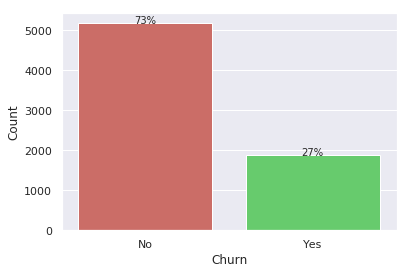

In [15]:
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

We can get use frequency counts charts to get an understanding of the categorical features relative to `Churn`  

- We can see that for the `gender` feature. We have relatively equal rates of churn by `gender`
- We can see that for the `InternetService` feature. We have higher churn for those that have "Fiber optic" service versus those with "DSL"


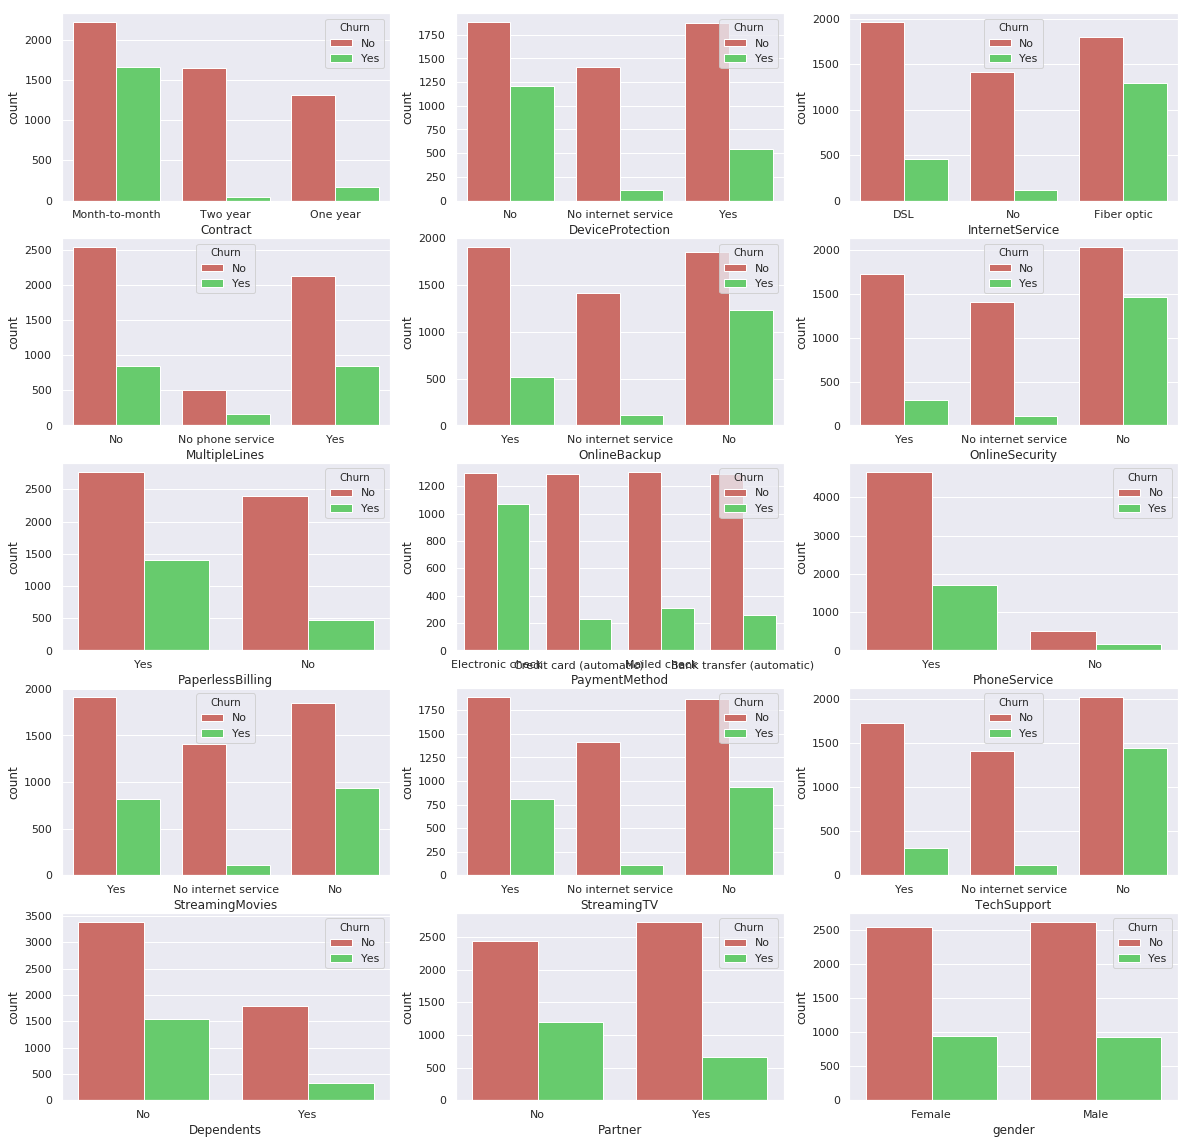

In [16]:
# Categorical feature count plots
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(20, 20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15 ]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue="Churn", data=df, ax=ax[i])

We can get use histrogram charts to get an understanding of the distribution of our continuous / numerical features relative to Churn.

- We can see that for the `MonthlyCharges` feature, customers that churn tend to pay higher monthly fees than those that stay.
- We can see that for the `tenure` feature, customers that churn tend to be relatively new customers.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa879c7358>,
      dtype=object)

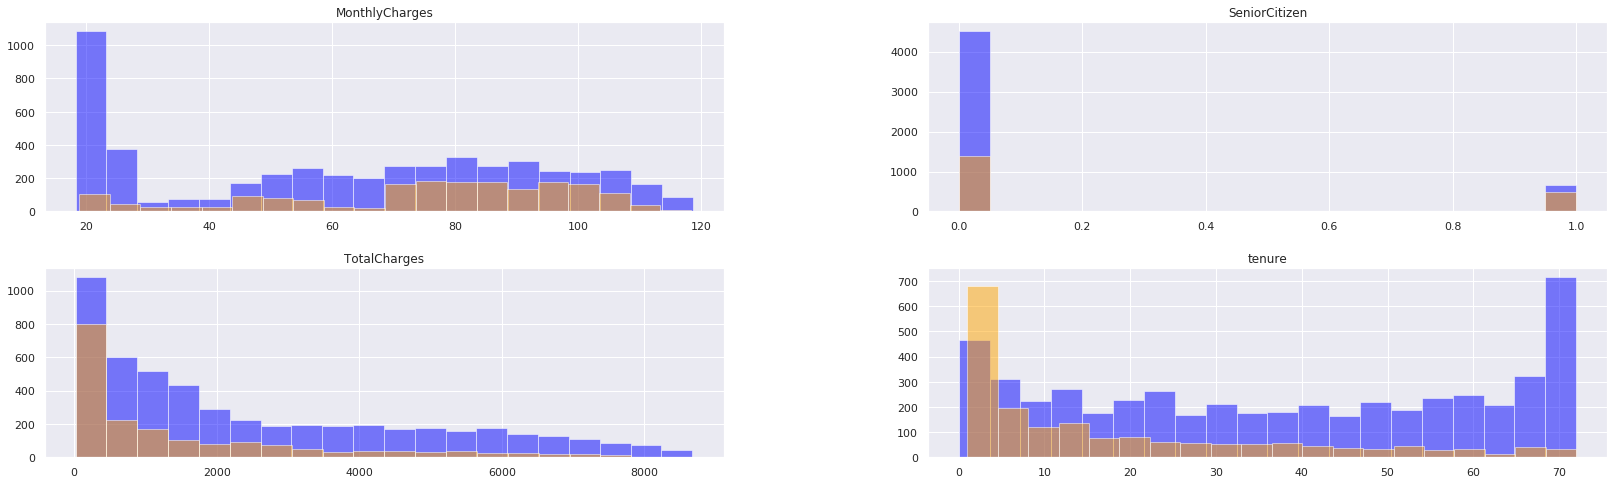

In [17]:
# Continuous feature histograms.
fig, ax = plt.subplots(2, 2, figsize=(28, 8))
df[df.Churn == 'No'][continuous_features].hist(bins=20, color="blue", alpha=0.5, ax=ax)
df[df.Churn == 'Yes'][continuous_features].hist(bins=20, color="orange", alpha=0.5, ax=ax)

# Or use displots
#sns.set_palette("hls", 3)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
#ax = [ax1, ax2, ax3, ax4]
#for i in range(len(continuous_features)):
#    sns.distplot(df[continuous_features[i]], bins=20, hist=True, ax=ax[i])

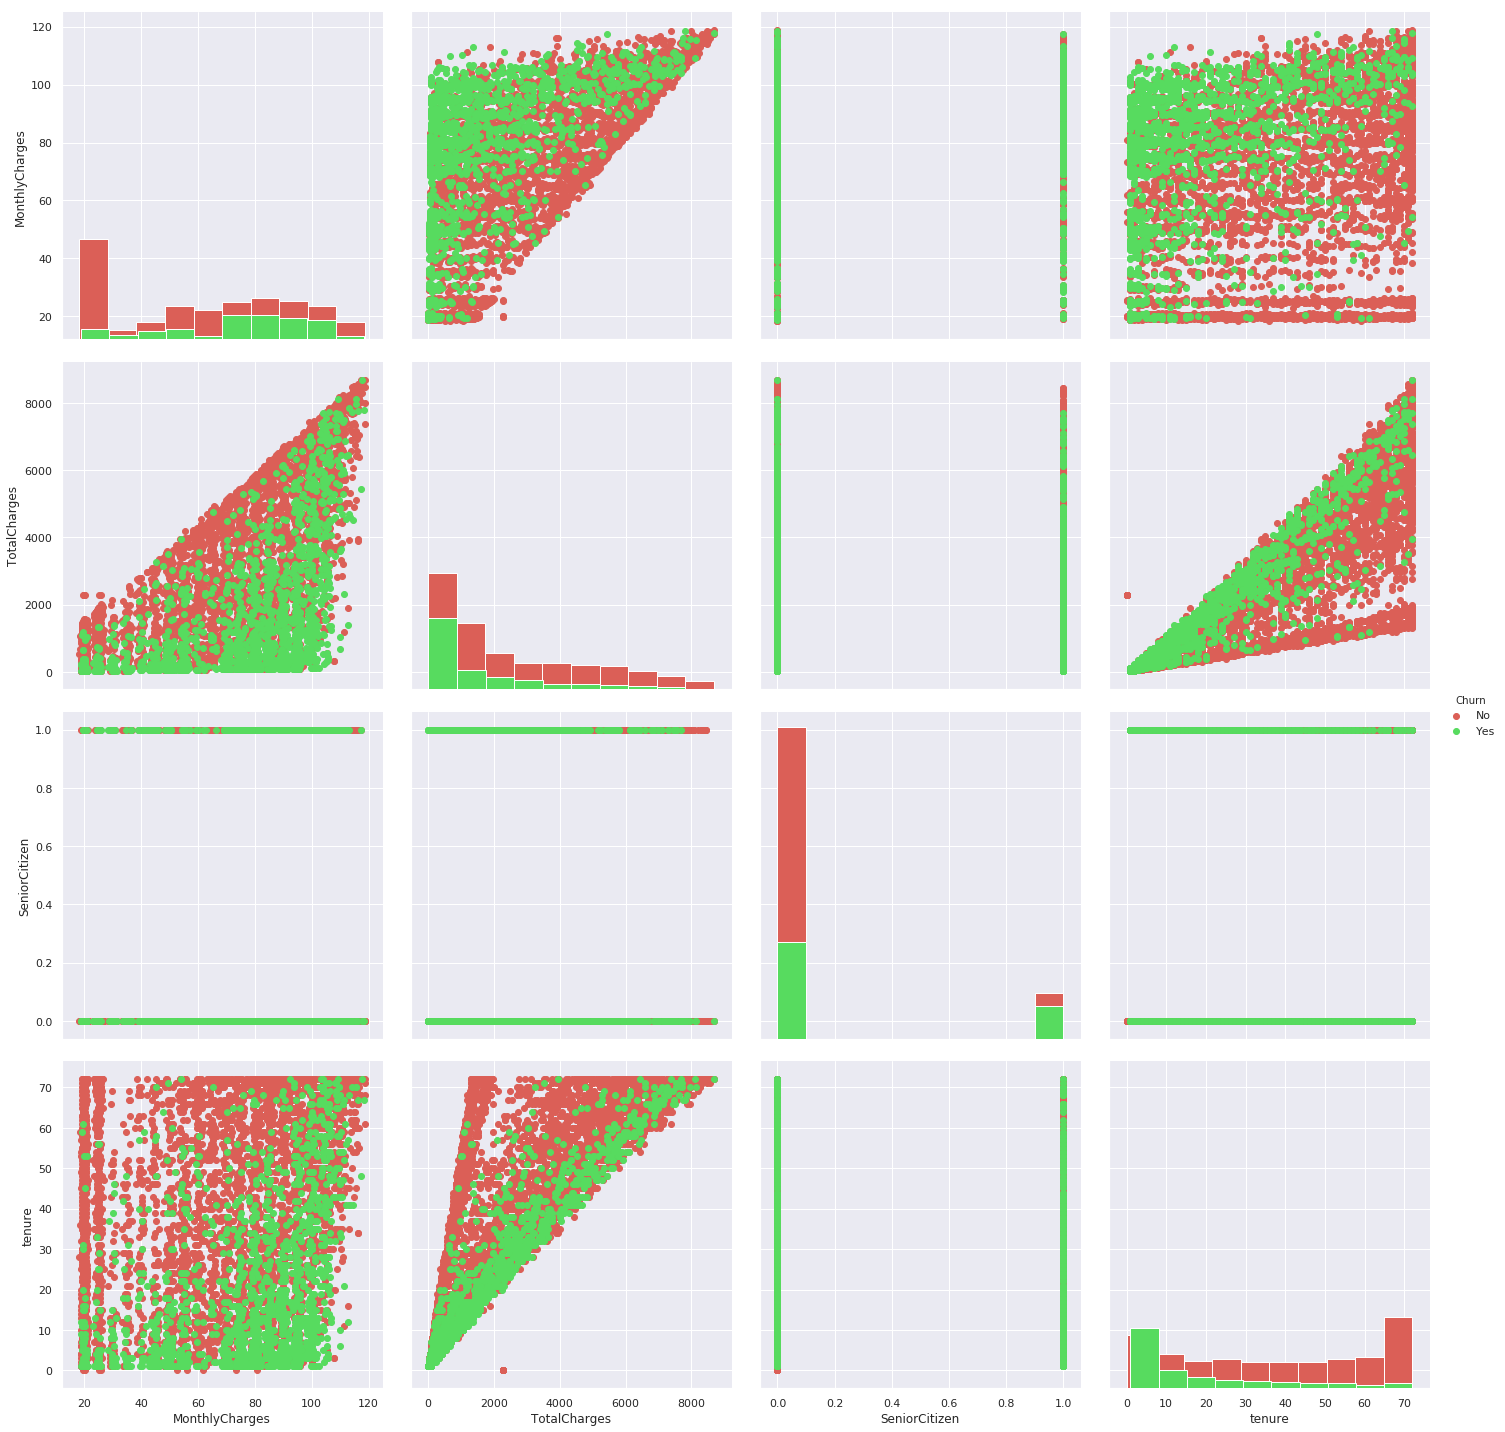

In [18]:
# Create Grid for pairwise relationships
gr = sns.PairGrid(df, height=5, hue="Churn")
gr = gr.map_diag(plt.hist)
gr = gr.map_offdiag(plt.scatter)
gr = gr.add_legend()

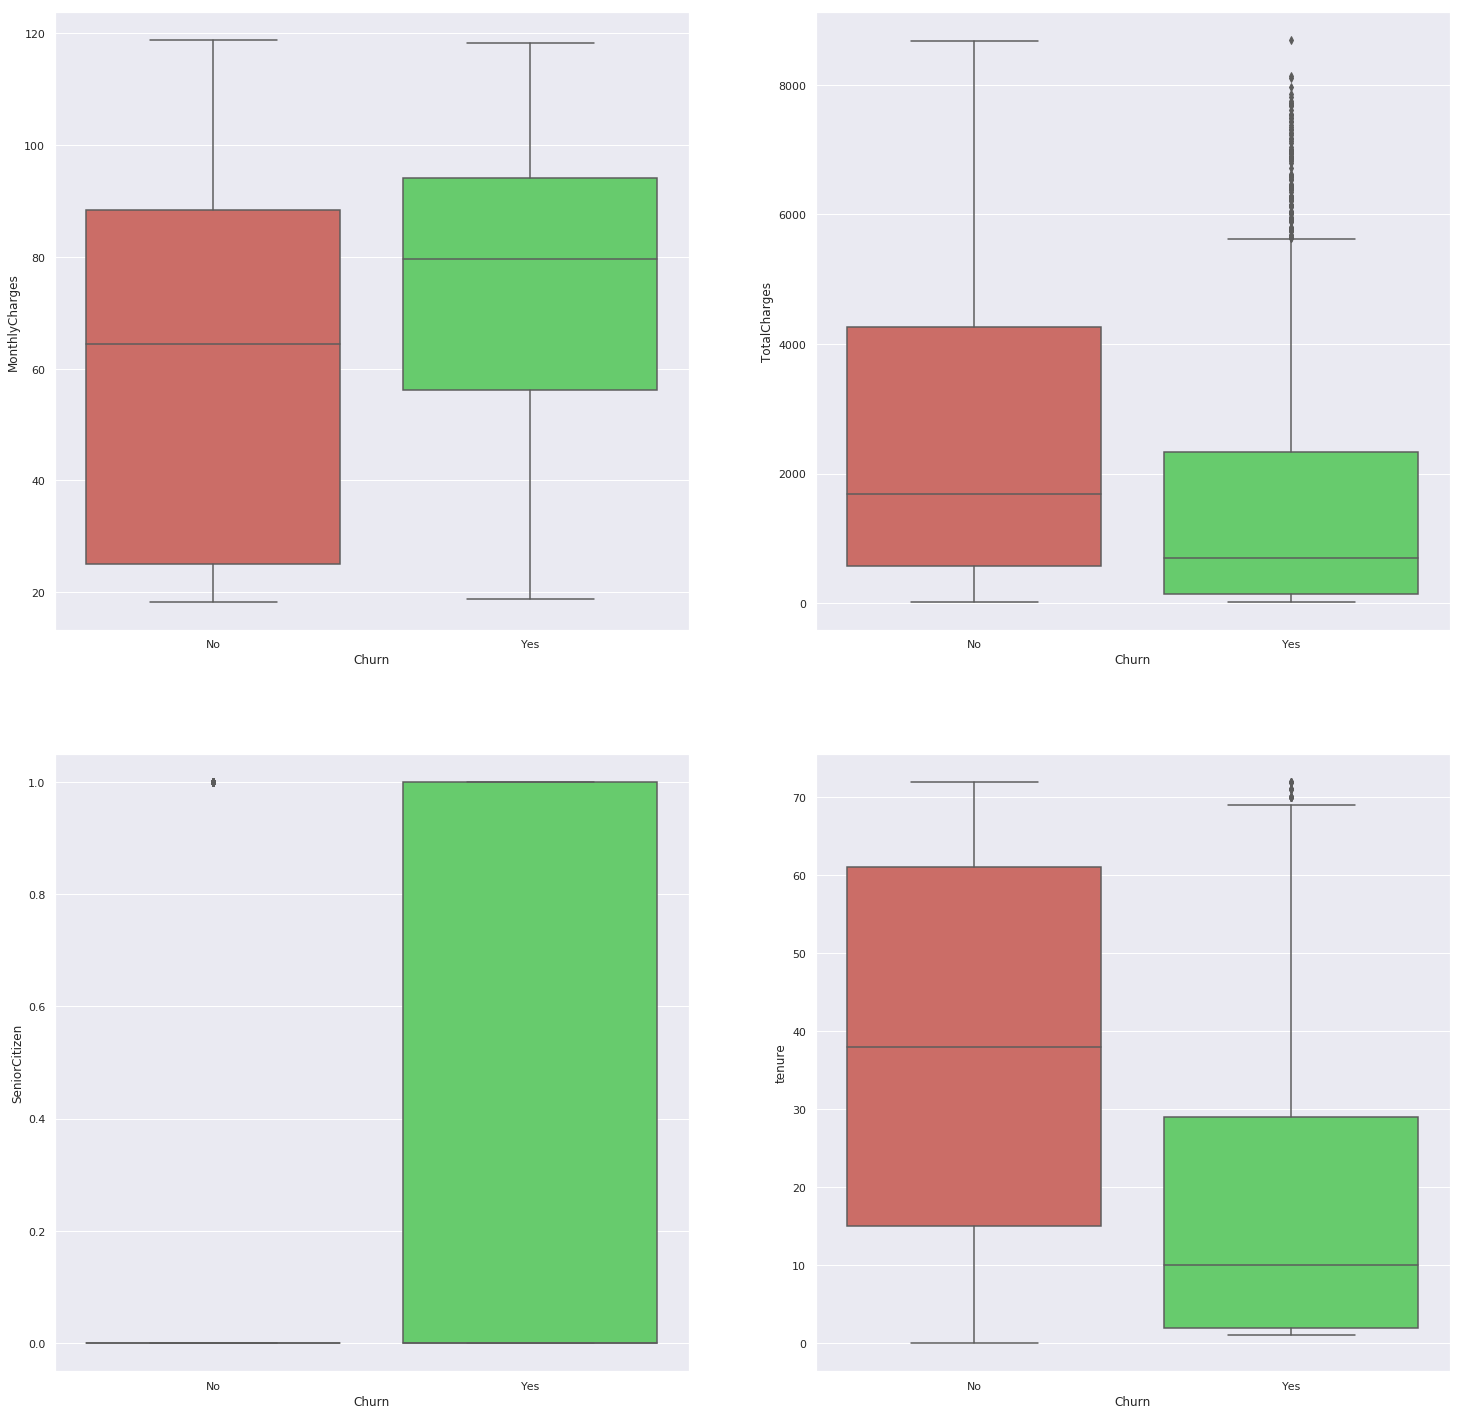

In [19]:
# Plot boxplots of numerical columns. More variation in the boxplot implies higher significance. 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4]

for i in range(len(continuous_features)):
    sns.boxplot(x = 'Churn', y = continuous_features[i], data=df, ax=ax[i])

## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [20]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(Churn='No', Contract='Month-to-month', DeviceProtection='No', InternetService='DSL', MonthlyCharges=78.5, MultipleLines='No', OnlineBackup='Yes', OnlineSecurity='Yes', PaperlessBilling='Yes', PaymentMethod='Electronic check', PhoneService='Yes', StreamingMovies='Yes', StreamingTV='Yes', TechSupport='Yes', TotalCharges=571.05, Dependents='No', Partner='No', SeniorCitizen=0, gender='Female', tenure=7)

### 3.1 Split the data into training and test sets

In [21]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 5662
Number of records for evaluation: 1381


### 3.2 Examine the Spark DataFrame Schema
Look at the data types to determine requirements for feature engineering

In [22]:
spark_df.printSchema()

root
 |-- Churn: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- tenure: long (nullable = true)



### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

We are using the Pipeline package to build the development steps as pipeline. 
We are using StringIndexer to handle categorical / string features from the dataset. StringIndexer encodes a string column of labels to a column of label indices

We then use VectorAssembler to asemble these features into a vector. Pipelines API requires that input variables are passed in  a vector

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model


si_gender = StringIndexer(inputCol = 'gender', outputCol = 'gender_IX')
si_Partner = StringIndexer(inputCol = 'Partner', outputCol = 'Partner_IX')
si_Dependents = StringIndexer(inputCol = 'Dependents', outputCol = 'Dependents_IX')
si_PhoneService = StringIndexer(inputCol = 'PhoneService', outputCol = 'PhoneService_IX')
si_MultipleLines = StringIndexer(inputCol = 'MultipleLines', outputCol = 'MultipleLines_IX')
si_InternetService = StringIndexer(inputCol = 'InternetService', outputCol = 'InternetService_IX')
si_OnlineSecurity = StringIndexer(inputCol = 'OnlineSecurity', outputCol = 'OnlineSecurity_IX')
si_OnlineBackup = StringIndexer(inputCol = 'OnlineBackup', outputCol = 'OnlineBackup_IX')
si_DeviceProtection = StringIndexer(inputCol = 'DeviceProtection', outputCol = 'DeviceProtection_IX')
si_TechSupport = StringIndexer(inputCol = 'TechSupport', outputCol = 'TechSupport_IX')
si_StreamingTV = StringIndexer(inputCol = 'StreamingTV', outputCol = 'StreamingTV_IX')
si_StreamingMovies = StringIndexer(inputCol = 'StreamingMovies', outputCol = 'StreamingMovies_IX')
si_Contract = StringIndexer(inputCol = 'Contract', outputCol = 'Contract_IX')
si_PaperlessBilling = StringIndexer(inputCol = 'PaperlessBilling', outputCol = 'PaperlessBilling_IX')
si_PaymentMethod = StringIndexer(inputCol = 'PaymentMethod', outputCol = 'PaymentMethod_IX')


In [24]:
si_Label = StringIndexer(inputCol="Churn", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

### 3.4 Create a single vector

In [25]:
va_features = VectorAssembler(inputCols=['gender_IX',  'SeniorCitizen', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', \
                                         'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', \
                                         'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'TotalCharges', 'MonthlyCharges'], outputCol="features")

### 3.5 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

In [26]:
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_gender, si_Partner, si_Dependents, si_PhoneService, si_MultipleLines, si_InternetService, si_OnlineSecurity, si_OnlineBackup, si_DeviceProtection, \
                            si_TechSupport, si_StreamingTV, si_StreamingMovies, si_Contract, si_PaperlessBilling, si_PaymentMethod, si_Label, va_features, \
                            classifier, label_converter])

model = pipeline.fit(train_data)

In [27]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.686592


## 4.0 Save the model and test data

Now the model can be saved for future deployment. The model will be saved using the Watson Machine Learning client, to a deployment space.

**<font color='red'><< UPDATE THE VARIABLE 'MODEL_NAME' TO A UNIQUE NAME>></font>**

**<font color='red'><< UPDATE THE VARIABLE 'DEPLOYMENT_SPACE_NAME' TO THE NAME OF THE DEPLOYMENT SPACE CREATED PREVIOUSLY>></font>**

In [28]:

MODEL_NAME = "Telco Customer Churn Model"
DEPLOYMENT_SPACE_NAME = 'Telco Customer Churn Space'


### 4.1 Save the model to ICP4D local Watson Machine Learning

<font color='red'>Replace the `username` and `password` values of `*****` with your Cloud Pak for Data `username` and `password`. The value for `url` should match the `url` for your Cloud Pak for Data cluster.</font>

In [29]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials = {
                   "url": "*****",
                   "username": "*****",
                   "password" : "*****",
                   "instance_id": "wml_local",
                   "version" : "2.5.0"
                  }

client = WatsonMachineLearningAPIClient(wml_credentials)

In [30]:
client.spaces.list()

------------------------------------  --------------------------  ------------------------
GUID                                  NAME                        CREATED
a05db957-4af9-4b4d-9883-23e248f25ddc  Telco Customer Churn Space  2020-05-20T20:08:42.125Z
------------------------------------  --------------------------  ------------------------


### Use the desired space as the `default_space`

The deployment space ID will be looked up based on the name specified above. If you do not receive a space GUID as an output to the next cell, do not proceed until you have created a deployment space.

In [31]:
# Be sure to update the name of the space with the one you want to use.
client.spaces.list()
all_spaces = client.spaces.get_details()['resources']
space_id = None
for space in all_spaces:
    if space['entity']['name'] == DEPLOYMENT_SPACE_NAME:
        space_id = space["metadata"]["guid"]
        print("\nDeployment Space GUID: ", space_id)

if space_id is None:
    print("WARNING: Your space does not exist. Create a deployment space before proceeding to the next cell.")
    #space_id = client.spaces.store(meta_props={client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["guid"]

------------------------------------  --------------------------  ------------------------
GUID                                  NAME                        CREATED
a05db957-4af9-4b4d-9883-23e248f25ddc  Telco Customer Churn Space  2020-05-20T20:08:42.125Z
------------------------------------  --------------------------  ------------------------

Deployment Space GUID:  a05db957-4af9-4b4d-9883-23e248f25ddc


In [32]:
# Now set the default space to the GUID for your deployment space. If this is successful, you will see a 'SUCCESS' message.
client.set.default_space(space_id)

'SUCCESS'

#### Save the Model

In [33]:
# Store our model
model_props = {client.repository.ModelMetaNames.NAME: MODEL_NAME,
               client.repository.ModelMetaNames.RUNTIME_UID : "spark-mllib_2.3",
               client.repository.ModelMetaNames.TYPE : "mllib_2.3"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)

print(json.dumps(published_model, indent=3))

{
   "metadata": {
      "guid": "34b02ecf-58ac-40fd-83bc-0637004ee7be",
      "id": "34b02ecf-58ac-40fd-83bc-0637004ee7be",
      "modified_at": "2020-05-20T20:10:28.002Z",
      "created_at": "2020-05-20T20:10:22.002Z",
      "owner": "1000331052",
      "href": "/v4/models/34b02ecf-58ac-40fd-83bc-0637004ee7be?space_id=a05db957-4af9-4b4d-9883-23e248f25ddc"
   },
   "entity": {
      "name": "Telco Customer Churn Model",
      "training_data_references": [
         {
            "location": {
               "bucket": "not_applicable"
            },
            "type": "fs",
            "connection": {
               "access_key_id": "not_applicable",
               "secret_access_key": "not_applicable",
               "endpoint_url": "not_applicable"
            },
            "schema": {
               "id": "1",
               "type": "struct",
               "fields": [
                  {
                     "name": "Churn",
                     "type": "string",
                

In [34]:
# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()
client.deployments.list()

# client.repository.delete('GUID of stored model')
# client.deployments.delete('GUID of deployed model')


------------------------------------  --------------------------  ------------------------  ---------
GUID                                  NAME                        CREATED                   TYPE
34b02ecf-58ac-40fd-83bc-0637004ee7be  Telco Customer Churn Model  2020-05-20T20:10:22.002Z  mllib_2.3
------------------------------------  --------------------------  ------------------------  ---------
----  ----  -----  -------  -------------
GUID  NAME  STATE  CREATED  ARTIFACT_TYPE
----  ----  -----  -------  -------------


## 5.0 Save Test Data

We will save the test data we used to evaluate the model to our project. Although not required, this will make it easier to run batch tests later on.

In [35]:
write_score_CSV=test_data.toPandas().drop(['Churn'], axis=1)
write_score_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLBatchScore.csv', sep=',', index=False)
#project.save_data('TelcoCustomerSparkMLBatchScore.csv', write_score_CSV.to_csv())

write_eval_CSV=test_data.toPandas()
write_eval_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLEval.csv', sep=',', index=False)
#project.save_data('TelcoCustomerSparkMLEval.csv', write_eval_CSV.to_csv())

## Congratulations, you have created a model based on customer churn data, and deployed it to Watson Machine Learning!